***Code to compute the objective measures of each algorithm***

In [1]:
import pandas as pd
import os
import pathlib
from lenskit import crossfold as xf
from lenskit.algorithms import Recommender, item_knn, user_knn, als
from lenskit.batch import predict
from lenskit.metrics.predict import user_metric, rmse
from sklearn.metrics.pairwise import cosine_similarity
import csv

BASE_DIR = pathlib.Path().resolve()

Ajust your path that it matches the location of the data files needed in generating_rec_lists.ipynb

In [5]:
book_df = pd.read_csv(os.path.join(BASE_DIR, '../recommendations/df_books.csv'))
user_df = pd.read_csv(os.path.join(BASE_DIR, '../recommendations/df_users.csv'))

***ACCURACY RMSE SCORES***

The RMSE metric is calculated by regarding the difference of the predicted rating and the actual rating of the last 5 items of each user. To ensure that there is enough data, only user ratings where the user has done 15 ratings are considered.

In [7]:
# Filter users with at least 15 ratings
user_counts = user_df['user_id'].value_counts()
users_with_enough_ratings = user_counts[user_counts >= 15].index
filtered_df = user_df[user_df['user_id'].isin(users_with_enough_ratings)]

Rename some columns for the fitting process for the algorithms

In [8]:
model_df = filtered_df[['book_id', 'user_id', 'user_rating']]
model_df = model_df.rename(columns={'book_id': 'item', 'user_id': 'user', 'user_rating': 'rating'})

Algorithm configuration

In [9]:
nnbrs = 20
min_nbrs = 1
min_sim = 0.1
feedback = 'explicit'
center = True

algo_ii = item_knn.ItemItem(nnbrs=nnbrs, min_nbrs=min_nbrs, min_sim=min_sim, feedback=feedback, center=center)

In [10]:
nnbrs = 30
min_nbrs = 1
min_sim = 0.1
feedback = 'explicit'
center = True

algo_uu = user_knn.UserUser(nnbrs=nnbrs, min_nbrs=min_nbrs, min_sim=min_sim, feedback=feedback, center=center)

In [11]:
features = 50
iterations = 20
reg = 0.1
damping = 5

algo_als = als.BiasedMF(features=features, iterations=iterations, reg=reg, damping=damping)

Dictionary for storing the RMSE values

In [12]:
# Create a dictionary to store RMSE values for each algorithm
rmse_values = {}

Splitting the data based on the test_size attributes into train and test data

In [13]:
test_size = 5
# Split the data into training and testing sets
test_data = model_df.groupby('user').tail(test_size).copy()
train_data = model_df.drop(test_data.index).copy()

Generating the recommendations, predicting the ratings for the test data and calculating the RMSE score for each algorithm

In [30]:
# Create a copy of the algorithm
algo_copy_ii = Recommender.adapt(ii)
    
# Fit the algorithm on the training data
algo_copy_ii.fit(train_data)

print('Finished Fitting II')

# Generate predictions for the test set
preds_ii = predict(algo_copy_ii, test_data)

print('Finished Predicting II')

# Calculate the overall RMSE
overall_rmse_ii = rmse(preds_ii['prediction'], preds_ii['rating'])

print(overall_rmse_ii)

# Store the overall RMSE in the dictionary
rmse_values['ItemItem'] = overall_rmse_ii

Finished Fitting II
Finished Predicting II
1.0451782898462219


In [31]:
# Create a copy of the algorithm
algo_copy_uu = Recommender.adapt(uu)
    
# Fit the algorithm on the training data
algo_copy_uu.fit(train_data)

print('Finished Fitting UU')

# Generate predictions for the test set
preds_uu = predict(algo_copy_uu, test_data)

print('Finished Predicting UU')

# Calculate the overall RMSE
overall_rmse_uu = rmse(preds_uu['prediction'], preds_uu['rating'])

print(overall_rmse_uu)

# Store the overall RMSE in the dictionary
rmse_values['UseUser'] = overall_rmse_uu

Finished Fitting UU
Finished Predicting UU
1.19668077564113


In [32]:
# Create a copy of the algorithm
algo_copy_als = Recommender.adapt(als)
    
# Fit the algorithm on the training data
algo_copy_als.fit(train_data)

print('Finished Fitting ALS')

# Generate predictions for the test set
preds_als = predict(algo_copy_als, test_data)

print('Finished Predicting ALS')

# Calculate the overall RMSE
overall_rmse_als = rmse(preds_als['prediction'], preds_als['rating'])

print(overall_rmse_als)

# Store the overall RMSE in the dictionary
rmse_values['ALS'] = overall_rmse_als

Finished Fitting ALS
Finished Predicting ALS
1.1407774761288334


Create a dataframe with the results and write a csv file

In [100]:
RMSE_df = pd.DataFrame({'Algorithm' : ['ItemItem', 'UserUser', 'ALS'],
                 'RMSE Score' : [1.0451782898462219, 1.19668077564113, 1.1407774761288334]})
RMSE_df.to_csv('RMSE.csv', index=False)

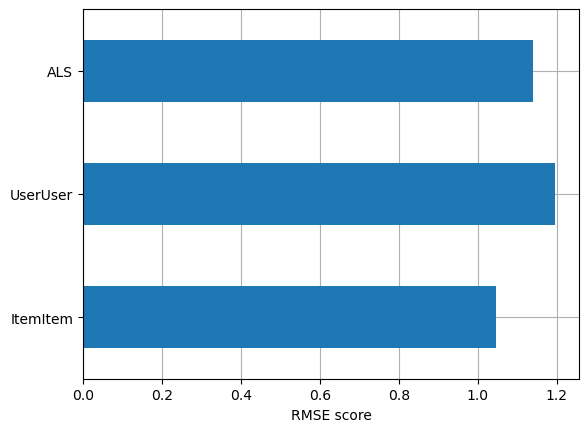

In [107]:
ax = RMSE_df.plot(kind='barh', legend=False, y='RMSE Score', x='Algorithm')
ax.set_xlabel('RMSE score')
ax.set_ylabel('')
ax.grid(True)
ax.set_axisbelow(True)

***NOVELTY MEAN POPULARITY RANK SCORES***

Merge user and book data frame to include the 'title_without_series' column in the user dataframe. This will be important in a few steps.

In [26]:
# Merge user_df with book_table to get book titles
user_df_with_titles = pd.merge(user_df, book_df[['book_id', 'title_without_series']], on='book_id', how='left')

Create the Popularity Dataframe by grouping unique combinations of book_id and title_without_series combinations and conunting their occurrences in the user dataframe.

In [27]:
# Count occurrences of each item in the reviews
item_popularity_df = user_df_with_titles.groupby(['book_id', 'title_without_series']).size().reset_index(name='popularity')

Now the decision of including the title comes in play. Since the dataset contains multiple entries with different ID's concerning the same book (this can be a result of different prints or editions) one can not just look up the popularity of the mentioned ID but has to include the popularity of other editions. Because of that, the dataframe is again grouped by the title and the popularity is summed up.

In [39]:
# Aggregate popularity scores based on book title
aggregated_popularity_df = item_popularity_df.groupby('title_without_series')['popularity'].sum().reset_index()
aggregated_popularity_df['popularity_rank'] = aggregated_popularity_df['popularity'].rank(ascending=False)

Read the saved recommendations and rename specific columns to match the join in a few steps. The generating_rec_lists.ipynb file has to be executed first and the paths have to be adjusted to point at the generated csv files.

In [40]:
recs_ii_df = pd.read_csv(os.path.join(BASE_DIR, '../recs_ii.csv'), index_col='Unnamed: 0')
recs_ii_df = recs_ii_df.rename(columns={'item': 'book_id'})
recs_uu_df = pd.read_csv(os.path.join(BASE_DIR, '../recs_uu.csv'), index_col='Unnamed: 0')
recs_uu_df = recs_uu_df.rename(columns={'item': 'book_id'})
recs_als_df = pd.read_csv(os.path.join(BASE_DIR, '../recs_als.csv'), index_col='Unnamed: 0')
recs_als_df = recs_als_df.rename(columns={'item': 'book_id'})

Merge the recommendations with the book frame to also have access to the book title

In [41]:
recommendations_ii_with_title = pd.merge(recs_ii_df, book_df[['book_id', 'title_without_series']], on='book_id', how='left')
recommendations_uu_with_title = pd.merge(recs_uu_df, book_df[['book_id', 'title_without_series']], on='book_id', how='left')
recommendations_als_with_title = pd.merge(recs_als_df, book_df[['book_id', 'title_without_series']], on='book_id', how='left')

Merge the recommendations containing the titles witht the aggregated popularity on the book title

In [46]:
# Merge with popularity to get popularity ranks for recommended items
recommendations_ii_with_rank = pd.merge(recommendations_ii_with_title, aggregated_popularity_df, on='title_without_series', how='left')
recommendations_uu_with_rank = pd.merge(recommendations_uu_with_title, aggregated_popularity_df, on='title_without_series', how='left')
recommendations_als_with_rank = pd.merge(recommendations_als_with_title, aggregated_popularity_df, on='title_without_series', how='left')

For all three recommendation lists, calculate the mean popularity rank

In [43]:
# Calculate mean popularity rank
mean_popularity_rank_ii = recommendations_ii_with_rank['popularity_rank'].mean()
mean_popularity_rank_uu = recommendations_uu_with_rank['popularity_rank'].mean()
mean_popularity_rank_als = recommendations_als_with_rank['popularity_rank'].mean()

Create a dataframe with the results and write a csv file

In [44]:
MeanPopRank_df = pd.DataFrame({'Algorithm' : ['ItemItem', 'UserUser', 'ALS'],
                 'Mean Pop Rank Score' : [mean_popularity_rank_ii, mean_popularity_rank_uu, mean_popularity_rank_als]})
MeanPopRank_df.to_csv('MeanPopRank.csv', index=False)

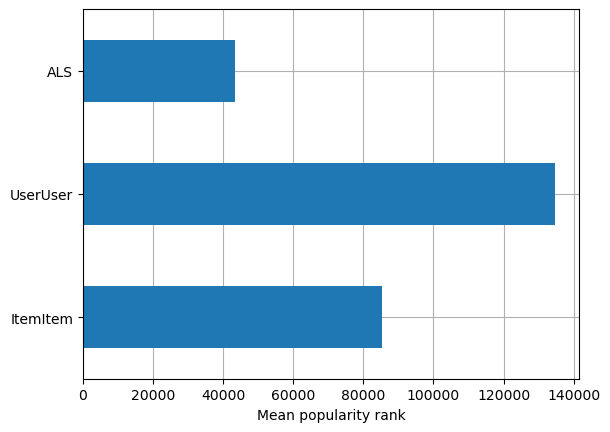

In [45]:
ax = MeanPopRank_df.plot(kind='barh', legend=False, y='Mean Pop Rank Score', x='Algorithm')
ax.set_xlabel('Mean popularity rank')
ax.set_ylabel('')
ax.grid(True)
ax.set_axisbelow(True)

***DIVERSITY INTRA-LIST SIMILARITY***

You will need the data files (glmer.csv, metadata.json) available in the book-genome.zip from https://grouplens.org/datasets/book-genome/. Adjust the paths accordingly

In [56]:
tag_score_df = pd.read_csv(os.path.join(BASE_DIR, 'glmer.csv'))
metadata_books = pd.read_json(os.path.join(BASE_DIR, 'metadata.json'), lines=True)
metadata_books = metadata_books.rename(columns={'title': 'title_without_series'})

Create a pivot table from the data and fill all missing entries with zeros

In [48]:
# Pivot the DataFrame to get the matrix form
tag_matrix = tag_score_df.pivot(index='item_id', columns='tag', values='score')

# Fill NaN values with 0 (assuming NaN means no score for that tag)
tag_matrix = tag_matrix.fillna(0)
tag_matrix = tag_matrix.reset_index()
tag_matrix = pd.merge(tag_matrix, metadata_books[['title_without_series', 'item_id']], on='item_id', how='left')

columns = tag_matrix.columns.tolist()
columns = ['title_without_series'] + [col for col in columns if col != 'title_without_series']
tag_matrix = tag_matrix[columns]

In [49]:
tag_columns = tag_matrix.columns[2:]
tag_columns = tag_columns.tolist()

Merge the pivot table with the recommendations on the title

In [50]:
tag_ii = pd.merge(recommendations_ii_with_title, tag_matrix, on='title_without_series', how='left')
tag_ii.fillna(0, inplace=True)
tag_uu = pd.merge(recommendations_uu_with_title, tag_matrix, on='title_without_series', how='left')
tag_uu.fillna(0, inplace=True)
tag_als = pd.merge(recommendations_als_with_title, tag_matrix, on='title_without_series', how='left')
tag_als.fillna(0, inplace=True)

Calcualte the list similarity for all recommendation lists

In [51]:
tag_ii = tag_ii[tag_columns]
# Calculate cosine similarity matrix
similarity_matrix_ii = cosine_similarity(tag_ii)

# Create a dataframe from the similarity matrix
similarity_df_ii = pd.DataFrame(similarity_matrix_ii, columns=tag_ii.index, index=tag_ii.index)

# Calculate the mean intra-list similarity
intra_list_similarity_ii = similarity_df_ii.mean().mean()

print(f"Intra-list Similarity: {intra_list_similarity_ii}")

Intra-list Similarity: 0.0827080584825616


In [52]:
tag_uu = tag_uu[tag_columns]
# Calculate cosine similarity matrix
similarity_matrix_uu = cosine_similarity(tag_uu)

# Create a dataframe from the similarity matrix
similarity_df_uu = pd.DataFrame(similarity_matrix_uu, columns=tag_uu.index, index=tag_uu.index)

# Calculate the mean intra-list similarity
intra_list_similarity_uu = similarity_df_uu.mean().mean()

print(f"Intra-list Similarity: {intra_list_similarity_uu}")

Intra-list Similarity: 0.13995801573927563


In [53]:
tag_als = tag_als[tag_columns]
# Calculate cosine similarity matrix
similarity_matrix_als = cosine_similarity(tag_als)

# Create a dataframe from the similarity matrix
similarity_df_als = pd.DataFrame(similarity_matrix_als, columns=tag_als.index, index=tag_als.index)

# Calculate the mean intra-list similarity
intra_list_similarity_als = similarity_df_als.mean().mean()

print(f"Intra-list Similarity: {intra_list_similarity_als}")

Intra-list Similarity: 0.13704973872813703


In [54]:
Intra_list_similarity_df = pd.DataFrame({'Algorithm' : ['ItemItem', 'UserUser', 'ALS'],
                 'Intra-list Similarity' : [intra_list_similarity_ii, intra_list_similarity_uu, intra_list_similarity_als]})
Intra_list_similarity_df.to_csv('IntraListSimilarity.csv', index=False)

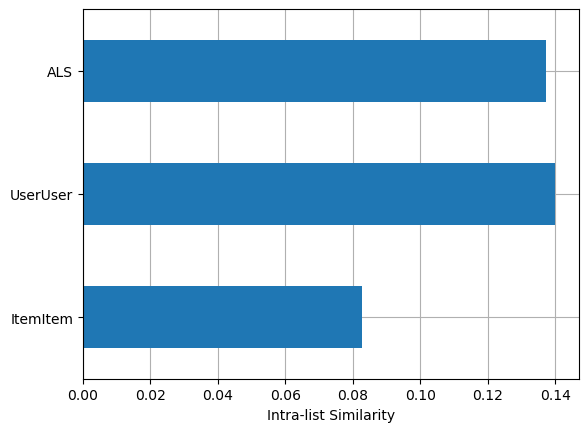

In [55]:
ax = Intra_list_similarity_df.plot(kind='barh', legend=False, y='Intra-list Similarity', x='Algorithm')
ax.set_xlabel('Intra-list Similarity')
ax.set_ylabel('')
ax.grid(True)
ax.set_axisbelow(True)